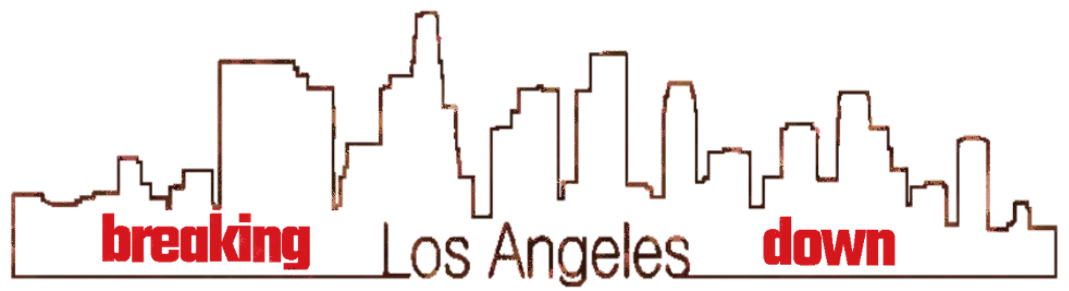

<hr style="border: 1px solid black;border-radius: 5px">
<div style="text-align: center;vertical-align: middle;line-height: 45px;font-size: 25px;color:black;font-weight: bold;">Breaking Down LA : Redefining and labelling Los Angeles Neighbourhoods through AirBnB Listings’ Non-Geographical Cluster labels</div>
<hr style="border: 1px solid black;border-radius: 5px">

#### Packages Included

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import re
import pandas as pd
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import stop_words
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.metrics import calinski_harabasz_score, silhouette_score
from scipy.spatial.distance import euclidean, cityblock
from collections import Counter
from sklearn.base import clone
import geopandas
import fiona
from wordcloud import WordCloud
%matplotlib inline

#### Functions to be Used

In [43]:

def pooled_within_ssd(X, y, centroids, dist):
    """Compute pooled within-cluster sum of squares around the cluster mean
    
    Parameters
    ----------
    X : array
        Design matrix with each row corresponding to a point
    y : array
        Class label of each point
    centroids : array
        Number of pairs to sample
    dist : callable
        Distance between two points. It should accept two arrays, each 
        corresponding to the coordinates of each point
        
    Returns
    -------
    float
        Pooled within-cluster sum of squares around the cluster mean
    """
    x_bar = {i : c for i, c in enumerate(centroids)}
    points = {i : list(y).count(i) for i in set(y)}
    pooled_sum = 0
    for x_i, y_i in zip(X, y):
        pooled_sum += (1/(2*points[y_i])) * dist(x_i, x_bar[y_i])**2
    return pooled_sum

def gap_statistic(X, y, centroids, dist, b, clusterer, random_state=None):
    """Compute the gap statistic
    
    Parameters
    ----------
    X : array
        Design matrix with each row corresponding to a point
    y : array
        Class label of each point
    centroids : array
        Number of pairs to sample
    dist : callable
        Distance between two points. It should accept two arrays, each 
        corresponding to the coordinates of each point
    b : int
        Number of realizations for the reference distribution
    clusterer : KMeans
        Clusterer object that will be used for clustering the reference 
        realizations
    random_state : int, default=None
        Determines random number generation for realizations
        
    Returns
    -------
    gs : float
        Gap statistic
    gs_std : float
        Standard deviation of gap statistic
    """
    rng = np.random.default_rng(random_state)
    
    null_X = np.array([[[rng.uniform(x.min(),x.max()) for x in X.T]
            for _ in range(len(X))] for _ in range(b)])
    null_y = np.array([clusterer.fit_predict(x) for x in null_X])
    null_centroids = [[x[y==i].mean(axis=0) for i in range(len(centroids))]
                      for x, y in zip(null_X, null_y)]
    pooled_sum = pooled_within_ssd(X, y, centroids, dist)
    gap = [np.log(pooled_within_ssd(x, y, c, dist)) - np.log(pooled_sum)
                        for x, y, c in zip(null_X, null_y, null_centroids)]
    
    return np.mean(gap), np.std(gap)

def cluster_range(X, clusterer, k_start, k_stop, actual=None):
    ys = []
    inertias = []
    chs = []
    scs = []
    gss = []
    gssds = []
    ps = []
    amis = []
    ars = []
    
    for k in range(k_start, k_stop+1):
        clusterer_k = clone(clusterer)
        # YOUR CODE HERE
        clusterer_k.set_params(n_clusters = k)
        y = clusterer_k.fit_predict(X)
        
        ys.append(y)
        inertias.append(clusterer_k.inertia_)
        chs.append(calinski_harabasz_score(X, y))
        scs.append(silhouette_score(X, y))
        
        if actual is not None:
            ps.append(purity(actual, y))
            amis.append(adjusted_mutual_info_score(actual, y))
            ars.append(adjusted_rand_score(actual, y))
        
        gs = gap_statistic(X, y, clusterer_k.cluster_centers_, 
                                 euclidean, 5, 
                                 clone(clusterer).set_params(n_clusters=k), 
                                 random_state=1337)
        
        gss.append(gs[0])
        gssds.append(gs[1])
    
    res = {'ys' : ys, 'inertias' : inertias, 'chs' : chs, 
        'gss' : gss, 'gssds' : gssds, 'scs' : scs}
    
    if actual is not None:
        res['ps'] = ps
        res['amis'] = amis
        res['ars'] = ars
        
    return res

def plot_clusters(X, ys):
    """Plot clusters given the design matrix and cluster labels"""
    k_max = len(ys) + 1
    k_mid = k_max//2 + 2
    fig, ax = plt.subplots(2, k_max//2, dpi=150, sharex=True, sharey=True, 
                           figsize=(10,5), subplot_kw=dict(aspect='equal'),
                           gridspec_kw=dict(wspace=0.01))
    fig.suptitle("Clustering of data set with different values of k")
    for k,y in zip(range(2, k_max+1), ys):
        if k < k_mid:
            ax[0][k%k_mid-2].scatter(*zip(*X), c=y, s=1, alpha=0.8)
            ax[0][k%k_mid-2].set_title('$k=%d$'%k)
        else:
            ax[1][k%k_mid].scatter(*zip(*X), c=y, s=1, alpha=0.8)
            ax[1][k%k_mid].set_title('$k=%d$'%k)
    return ax

def plot_internal(inertias, chs, scs, gss, gssds):
    """Plot internal validation values"""
    fig, ax = plt.subplots(figsize=(10,6))
    ks = np.arange(2, len(inertias)+2)
    ax.plot(ks, inertias, '-o', label='SSE')
    ax.plot(ks, chs, '-ro', label='CH')
    ax.set_xlabel('$k$')
    ax.set_ylabel('SSE/CH')
    lines, labels = ax.get_legend_handles_labels()
    ax2 = ax.twinx()
    ax2.errorbar(ks, gss, gssds, fmt='-go', label='Gap statistic')
    ax2.plot(ks, scs, '-ko', label='Silhouette coefficient')
    ax2.set_ylabel('Gap statistic/Silhouette')
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines+lines2, labels+labels2)
    return ax

<div style="width: 250px;height: 50px;border: 3px solid black;box-sizing: border-box;text-align: center;vertical-align: middle;line-height: 45px;font-size: 20px;color:#DD1316;font-weight: bold;">EXECUTIVE SUMMARY</div>

<p style="text-align: justify">One of the most visited cities in America is the Los Angeles City. It is coined as the home of stars and  tourists gather around Los Angeles for its scenic tourist spots and for fans to see their beloved celebrities. With the advent of the Real Estate Business boom, it is very crucial to know the details and description of real estate places around Los Angeles. With this study, we will be able to understand the different clustering derived from the features of Airbnb listings around Los Angeles.</p>
 
<p style="text-align: justify">Using a Kmeans Clustering, the study was able to cluster the Los Angeles Neighbourhood to three new distinct clusters with Different Characteristics. Cluster 0 can be considered the Prime Real Estate Place, Cluster 1, being the Business and Tourist Place and lastly, Cluster 2 as the Residential Oriented Place.</p> 


<div style="width: 200px;height: 50px;border: 3px solid black;box-sizing: border-box;text-align: center;vertical-align: middle;line-height: 45px;font-size: 20px;color:#DD1316;font-weight: bold;">INTRODUCTION</div>

**LOS ANGELES CITY (LA)**

<p style="text-align: justify"> Los Angeles has been known as the capital of the stars and celebrities and because of this, the price of real estate places like condominiums and apartments can be pricey. Los Angeles is considered as one of the priciest markets in terms of real estate with standard homes amounting to 600,000 USD. With this, it is easy to see how Los Angeles is one of the most profitable places in terms of tourism. There will always be a possibility of tourists walking around Los Angeles day and night. This is why a lot of investors and entrepreneurs invest in real estate places in Los Angeles and convert it to accommodation rooms for tourists. </p>

<p style="text-align: justify"> Real Estate Owners use different kinds of strategies to be able to market and advertise their units to their tourists, and one of them is listing their unit on the online rental platform Airbnb. Through this platform, tourists can privately book their preferred real estate places for their stay in Los Angeles.</p>

<p style="text-align: justify">Due to the popularity of Los Angeles City, a lot of listings of privately owned real estate places are listed on AirBnB. Tourists and Airbnb Users need to choose from tens of thousands of listings from more than a hundred different neighborhoods in Los Angeles with which the tourists have little-to-no background knowledge on. Due to this, a lot of negative experiences from staying in an unknown neighborhood can be observed based on the reviews.</p>

<p style="text-align: justify"> Assigning labels to these neighbourhoods according to the characteristics of the houses within and attractions nearby will definitely be of use to set expectations for new comers to the city of angels.</p>

**INSIDEAIRBNB**

<p style="text-align: justify">Inside Airbnb is an online website that acts as an online investigator that reports and shows scraped data from the property rental workplace Airbnb. </p>
    
<p style="text-align: justify">Inside Airbnb is an independent project that was made by Murray Cox in 2016 to highlight illegal renting on the Airbnb Site and gentrification caused by landlords buying properties to rent on Airbnb. Murray Cox is an independent digital storyteller and activist. Before building the whole website, Cox first scraped information on the Airbnb site back in 2014 and compared it to a dataset that Airbnb publicly released. Through that comparison, Cox was able to conclude that Airbnb had removed over 1,000 listings that violated New York’s multiple dwelling law just before the data was released. This controversy sparked many arguments which led to the building of the website itself. </p>
    
<p style="text-align: justify">Through analyzing the Airbnb publicly available information, both on-site and on the app, the website provides different metrics and statistics that allow the users to see different visualization on the Airbnb data. The website also shows how Airbnb can be compared and competed with the residential housing market. As of Present, Inside Airbnb is publicly used by different cities, researchers, and the hotel trade business for data access and data accumulation. The sample overview depicting Los Angeles State can be seen in Figure 1[1].</p>
    
<p style="text-align: justify">The data from Inside Airbnb will contain the necessary features that will be very useful in concluding for this study.  
 </p>

*Figure 1: Sample Screenshot of Inside Airbnb depicting Los Angeles*
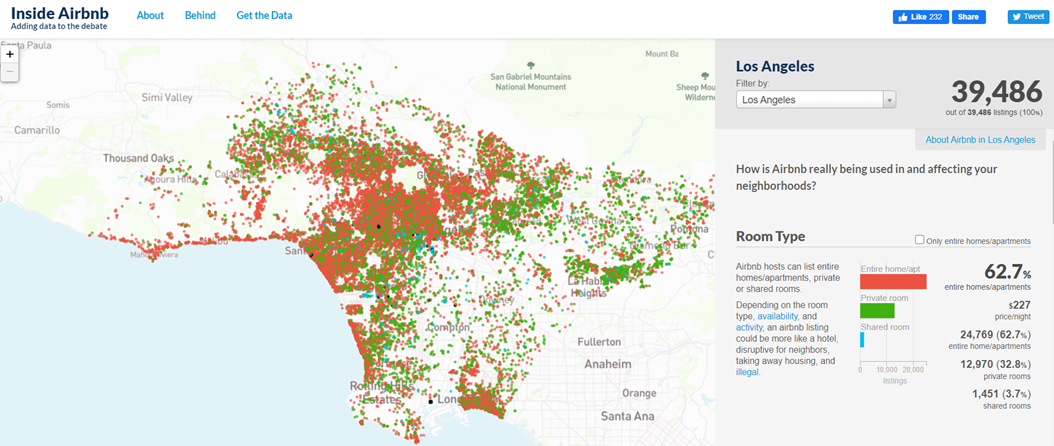

<div style="width: 260px;height: 50px;border: 3px solid black;box-sizing: border-box;text-align: center;vertical-align: middle;line-height: 45px;font-size: 20px;color:#DD1316;font-weight: bold;">PROBLEM STATEMENT</div>

  ####  *1. Can Los Angeles AirBnB listings be clustered and given labels based on non-geographic labels?*
(I.e. residential, tourist, city-center, etc.)

  ####  *2. Can the different neighbourhoods of Los Angeles city be labelled using the labels produced from clustering of Non-geographic and text information from the AirBnB listings within the city?*
(i.e. this location cluster is labelled as a tourist area because majority of its AirBnB listings are expensive and their descriptions indicate proximity to a tourist spot.) 
  

<div style="width: 200px;height: 50px;border: 3px solid black;box-sizing: border-box;text-align: center;vertical-align: middle;line-height: 45px;font-size: 20px;color:#DD1316;font-weight: bold;">BUSINESS VALUE</div>


- **Tourists**: Tourists are the main benificaries of this study. As newcomers to Los Angeles, they are the least informed about the neighbourhood that they will be staying at. The study is expected to give meaningful insight to where they will be staying for better management of expectations.


- **Real Estate / AirBnB Hosts**: Potential hosts of AirBnB's can use this study to see commonality between their place and similar listings within the same cluster. This can help them price their AirBnB listings, figure out what amenities to provide, or see how they can differentiate themselves from other listings.

<div style="width: 200px;height: 50px;border: 3px solid black;box-sizing: border-box;text-align: center;vertical-align: middle;line-height: 45px;font-size: 20px;color:#DD1316;font-weight: bold;">METHODOLOGY</div>

<p style="text-align: justify">To properly address the problem, the researchers will be needing viable data on regarding the different listings of AIrBnb in Los Angeles. Note that there are a wide array of selection for possible collection of data 
but for this study we will using a public dataset that originated from the Jojie Server. We can also download the original data set at http://insideairbnb.com/index.html .The Researchers will follow the general workflow defined below to arrive at a conclusion and recommendation.</p>



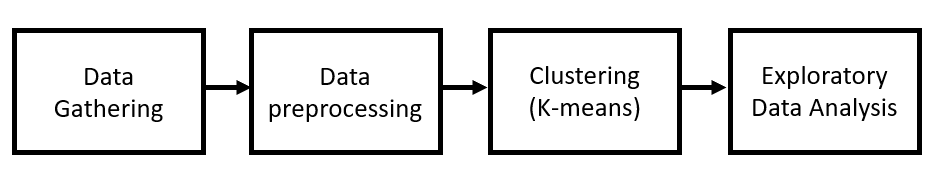

<div style="width: 220px;height: 50px;border: 3px solid black;box-sizing: border-box;text-align: center;vertical-align: middle;line-height: 45px;font-size: 20px;color:#DD1316;font-weight: bold;">DATA GATHERING AND DESCRIPTION</div>

**Data Gathering**

A public dataset inside jojie server can be used with the following link:

        /mnt/data/public/insideairbnb/data.insideairbnb.com/united-states/ca/los-angeles/2014-09-14/data/listings.csv.gz
        
NOTE: Extraction of the file was done locally.

**Data Description**

The data set contains information on the airbnb listings in Los AngelesThis data set has 45,053 rows corresponding to a unique id and 103 columns which relates to a quantitative and qualitative description of the listing and its host. 

In [44]:
df = pd.read_csv('listings.zip',low_memory=False)
print("Data set dimension",df.shape)
df.head()

Data set dimension (45053, 106)


id                        listing_url       scrape_id last_scraped  \
0   109   https://www.airbnb.com/rooms/109  20190914032935   2019-09-14   
1   344   https://www.airbnb.com/rooms/344  20190914032935   2019-09-14   
2  2708  https://www.airbnb.com/rooms/2708  20190914032935   2019-09-14   
3  2732  https://www.airbnb.com/rooms/2732  20190914032935   2019-09-14   
4  2864  https://www.airbnb.com/rooms/2864  20190914032935   2019-09-14   

                                                name  \
0  Amazing bright elegant condo park front *UPGRA...   
1                  Family perfect;Pool;Near Studios!   
2  Fireplace Mirrored Mini Suit (Website hidden b...   
3                              Zen Life at the Beach   
4  *Upscale Professional Home with Beautiful Studio*   

                                             summary  \
0  *** Unit upgraded with new bamboo flooring, br...   
1  This home is perfect for families; aspiring ch...   
2  Our best memory foam pillows you'll ever sleep...   
3                                                NaN   
4  Centrally located.... Furnished with 42 inch S...   

                                               space  \
0  *** Unit upgraded with new bamboo flooring, br...   
1  Cheerful & comfortable; near studios, amusemen...   
2  Flickering fireplace.  Blendtec® Designer 625 ...   
3  This is a three story townhouse with the follo...   
4  The space is furnished with Thomasville furnit...   

                                         description experiences_offered  \
0  *** Unit upgraded with new bamboo flooring, br...                none   
1  This home is perfect for families; aspiring ch...                none   
2  Our best memory foam pillows you'll ever sleep...                none   
3  This is a three story townhouse with the follo...                none   
4  Centrally located.... Furnished with 42 inch S...                none   

                               neighborhood_overview  ... instant_bookable  \
0                                                NaN  ...                f   
1  Quiet-yet-close to all the fun in LA! Hollywoo...  ...                t   
2  We are minutes away from the Mentor Language I...  ...                t   
3                                                NaN  ...                f   
4  What makes the neighborhood unique is that the...  ...                f   

  is_business_travel_ready          cancellation_policy  \
0                        f  strict_14_with_grace_period   
1                        f                     flexible   
2                        f  strict_14_with_grace_period   
3                        f  strict_14_with_grace_period   
4                        f  strict_14_with_grace_period   

  require_guest_profile_picture require_guest_phone_verification  \
0                             t                                f   
1                             f                                f   
2                             f                                f   
3                             f                                f   
4                             f                                f   

   calculated_host_listings_count  \
0                               1   
1                               1   
2                               2   
3                               2   
4                               1   

   calculated_host_listings_count_entire_homes  \
0                                            1   
1                                            1   
2                                            0   
3                                            1   
4                                            1   

  calculated_host_listings_count_private_rooms  \
0                                            0   
1                                            0   
2                                            2   
3                                            1   
4                                            0   

   calculated_host_listings_

<div style="width: 300px;height: 50px;border: 3px solid black;box-sizing: border-box;text-align: center;vertical-align: middle;line-height: 45px;font-size: 20px;color:#DD1316;font-weight: bold;">DATA PREPROCESSING</div>


Below are the steps in the data pre-processing:
1. Data Cleaning
2. Feature Extraction (TF-IDF Vectorization)
3. Normalization
3. Dimensionality Reduction (PCA)

**1. Data Cleaning**

The data set was initially cleaned by removing  Non-LA listings. 

In [45]:
df = df[df.city == 'Los Angeles']

The following columns were then dropped as these are deemed redundant and not useful for the study:

In [46]:
dropcols = ['id', 'listing_url', 'scrape_id', 'last_scraped', 'thumbnail_url',
            'medium_url', 'picture_url', 'xl_picture_url', 'host_id',
            'host_name', 'host_location', 'host_about', 'host_thumbnail_url',
            'host_url', 'host_picture_url', 'market', 'experiences_offered',
            'neighbourhood_group_cleansed', 'neighbourhood', 'zipcode',
            'smart_location', 'state', 'zipcode', 'smart_location',
            'country_code', 'country', 'host_acceptance_rate',
            'minimum_minimum_nights', 'maximum_minimum_nights',
            'minimum_maximum_nights', 'maximum_maximum_nights',
            'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm',
            'calendar_updated', 'has_availability', 'calendar_last_scraped',
            'first_review', 'last_review', 'license', 'jurisdiction_names',
            'host_neighbourhood', 'host_total_listings_count', 'street',
            'weekly_price', 'monthly_price', 'square_feet', 'name', 'summary',
            'city', 'notes', 'transit', 'access',
            'interaction', 'house_rules', 'host_response_rate',
            'is_business_travel_ready']

df_bnb = df.copy().drop(columns=dropcols)

Summary of cleaning:
1. Convert `host_since` date time entries to integers based on days since August 6, 2020.
2. Convert Boolean and Ordinal columns to integers
3. Convert price columns into float
4. When reasonable, NA = 0 for some columns (i.e. bed, bathroom, reviews_per_month)
5. For host_verifications: Converted it into an integer counting the number of sites the host is verified on
6. Dropped rows where the values could not be imputed
7. Reset index

In [47]:
# 1
df_bnb.host_since = (pd.to_datetime('2020-08-06')
                        - pd.to_datetime(df_bnb.host_since)).dt.days.fillna(0)

# 2
df_bnb.host_response_time = df_bnb.host_response_time.replace({
                                     'within an hour' : 0,
                                     'within a few hours' : 1,
                                     'within a day' : 2,
                                     'a few days or more' : 3})

factorizecols = ['host_is_superhost', 'host_has_profile_pic',
                 'host_identity_verified', 'is_location_exact',
                 'requires_license', 'instant_bookable',
                 'require_guest_profile_picture',
                'require_guest_phone_verification']
for factor in factorizecols:
    df_bnb[factor] = df_bnb[factor].replace({'f' : 0,
                                                  't' : 1,
                                                  np.nan : 0
                                            }).astype(float)

# 3
pricecols = ['price', 'extra_people', 'security_deposit', 'cleaning_fee']
for price in pricecols:
    df_bnb[price] = df_bnb[price].str.replace('[$.,]', '').str[:-2].astype(float)

# 4
numcols = ['bedrooms', 'beds', 'reviews_per_month',
                'host_listings_count', 'bathrooms',
          'security_deposit', 'cleaning_fee', 'extra_people']
for i in numcols:
    df_bnb[i] = df_bnb[i].replace(np.nan, 0).astype(float)

# 5
df_bnb.host_verifications = df_bnb.host_verifications.apply(lambda x: x.count("'")/2)

# 6
dropna = ['host_response_time', 'review_scores_rating', 'review_scores_accuracy',
              'review_scores_cleanliness', 'review_scores_checkin',
              'review_scores_communication', 'review_scores_location',
              'review_scores_value']
df_bnb = df_bnb.dropna(subset = dropna).reset_index(drop = True)

print("Data set dimension",df_bnb.shape)
df_bnb.head()

Data set dimension (18947, 52)


space  \
0  Flickering fireplace.  Blendtec® Designer 625 ...   
1  Do you want to live in paradise? We have a ver...   
2  Do you want to stay in paradise? We are close ...   
3  Our home, “THE CIRCLE” is known to the local L...   
4  Decorated with fresh flowers for the Holidays....   

                                         description  \
0  Our best memory foam pillows you'll ever sleep...   
1  Our home is located near Venice Beach without ...   
2  Our home is located near Venice Beach without ...   
3  Do you want a taste of Paradise? Our one-of-a-...   
4  Our best memory foam pillows; you'll ever slee...   

                               neighborhood_overview  host_since  \
0  We are minutes away from the Mentor Language I...      4342.0   
1  Our neighborhood is very quiet and save. There...      4172.0   
2  Our neighborhood is very quiet and save. There...      4172.0   
3  Our neighborhood is very quiet and save. There...      4172.0   
4  We are in the middle of one of the great citie...      4342.0   

   host_response_time  host_is_superhost  host_listings_count  \
0                 0.0                1.0                  2.0   
1                 0.0                1.0                  8.0   
2                 0.0                1.0                  8.0   
3                 0.0                1.0                  8.0   
4                 0.0                1.0                  2.0   

   host_verifications  host_has_profile_pic  host_identity_verified  ...  \
0                 5.0                   1.0                     1.0  ...   
1                 9.0                   1.0                     0.0  ...   
2                 9.0                   1.0                     0.0  ...   
3                 9.0                   1.0                     0.0  ...   
4                 5.0                   1.0                     1.0  ...   

  requires_license  instant_bookable          cancellation_policy  \
0              1.0               1.0  strict_14_with_grace_period   
1              1.0               1.0                     moderate   
2              1.0               1.0                     moderate   
3              1.0               1.0                     moderate   
4              1.0               1.0  strict_14_with_grace_period   

   require_guest_profile_picture require_guest_phone_verification  \
0                            0.0                              0.0   
1                            0.0                              0.0   
2                            0.0                              0.0   
3                            0.0                              0.0   
4                            0.0                              0.0   

  calculated_host_listings_count  calculated_host_listings_count_entire_homes  \
0                              2                                            0   
1                              4                                            1   
2                              4                                            1   
3                              4                                            1   
4                              2                                            0   

   calculated_host_listings_count_private_rooms  \
0                                             2   
1                                             3   
2                                             3   
3                                             3   
4                                             2   

   calculated_host_listings_count_shared_rooms  reviews_per_month  
0                                            0               0.33  
1                                            0               2.32  
2                                            0               1.60  
3                                            0               1.03  
4                                            0               0.14  

[5 rows x 52 columns]

After cleaning, the data set dimension is now reduced to 18947 rows and 51 columns.

The remaining columns can be described as follows:
* Descriptive Features - This features are those columns that contain descriptive words of the listings. Examples of this are the space and amenities.

* Non-Geographic Features - This features are those columns that contain numerical values pertaining to the listings. Examples of this are the Price, the Availability and the Minimum Nights.

* Geographic Features - Longitude, Latitude and Neighbourhood

For further data pre-processing, the data set will be segmented based on the type of features, namely descriptive features, non-geographic features and geo-graphic features as defined above. This is to allow for different pre-processing techniques that will be done for each feature set. 

The descriptive feature set is defined as df_text as shown below, geological feature set as df_geo and non-geological feature set as df_nongeo.

In [48]:
#Defining the columns for the descriptive and geological feature set
textcols = ['space', 'description', 'amenities', 'neighborhood_overview']
geocols = ['neighbourhood_cleansed', 'longitude', 'latitude']

#Segmenting the data set based on feature type
df_text = df_bnb.loc[:, textcols].fillna('')

df_text['details'] = df_text['description'] + df_text['amenities'] + \
                     df_text['space']

df_geo = df_bnb.loc[:, geocols]

df_nongeo = df_bnb.drop(columns = textcols + geocols)

#### Feature Extraction

For the descriptive feature set, features were extracted from the from corpus *Description, Space and Amenities* using a term frequency-inverse document frequency **TF-IDF vectorizer**. This vectorizer was used because it de-emphasizes very frequent and rare words, and by using these, the essence of the document can be better captured.

For the implementation, scikit-learn's TfidfVectorizer was used. For this problem, a word is considered all alphabetic characters bounded by a white-space. Stop words, or very common words in the English languages was also included on the vectorization process. Lastly, a min_df of 0.01, or words that appeared in less than 10% of the corpus were removed.

In [49]:
# Define stop words from sklearn
stopwords = list(stop_words.ENGLISH_STOP_WORDS)

# Vectorization
vectorizer = TfidfVectorizer(token_pattern=r'\b[a-z]+\b',
                             stop_words=stopwords,
                             min_df=0.01)
vectorizer.fit(df_text['details'])

# Convert vectorized text to a data frame
bow_text = pd.DataFrame.sparse.from_spmatrix(
    vectorizer.transform(df_text['details']),
    columns=vectorizer.get_feature_names(),
    index=df_text.index)

The vector representation of the descriptive feature set is shown below:

In [50]:
bow_text.head()

abbot  abbott  able  absolutely   ac  accents  access  accessible  \
0    0.0     0.0   0.0         0.0  0.0      0.0     0.0    0.046075   
1    0.0     0.0   0.0         0.0  0.0      0.0     0.0    0.000000   
2    0.0     0.0   0.0         0.0  0.0      0.0     0.0    0.000000   
3    0.0     0.0   0.0         0.0  0.0      0.0     0.0    0.000000   
4    0.0     0.0   0.0         0.0  0.0      0.0     0.0    0.129535   

   accommodate  accommodates  ...  workspace  world  www  yard      year  \
0          0.0           0.0  ...   0.018713    0.0  0.0   0.0  0.000000   
1          0.0           0.0  ...   0.019728    0.0  0.0   0.0  0.000000   
2          0.0           0.0  ...   0.022531    0.0  0.0   0.0  0.000000   
3          0.0           0.0  ...   0.019143    0.0  0.0   0.0  0.077887   
4          0.0           0.0  ...   0.017537    0.0  0.0   0.0  0.000000   

   years      yoga  york  young  zen  
0    0.0  0.000000   0.0    0.0  0.0  
1    0.0  0.000000   0.0    0.0  0.0  
2    0.0  0.177275   0.0    0.0  0.0  
3    0.0  0.000000   0.0    0.0  0.0  
4    0.0  0.000000   0.0    0.0  0.0  

[5 rows x 1226 columns]

#### One-hot encoding

For the vector representation of the categorical variables in the non-geological feature set, one-hot encoding was done.

In [51]:
df_nongeo = pd.get_dummies(df_nongeo)
df_nongeo.head()

host_since  host_response_time  host_is_superhost  host_listings_count  \
0      4342.0                 0.0                1.0                  2.0   
1      4172.0                 0.0                1.0                  8.0   
2      4172.0                 0.0                1.0                  8.0   
3      4172.0                 0.0                1.0                  8.0   
4      4342.0                 0.0                1.0                  2.0   

   host_verifications  host_has_profile_pic  host_identity_verified  \
0                 5.0                   1.0                     1.0   
1                 9.0                   1.0                     0.0   
2                 9.0                   1.0                     0.0   
3                 9.0                   1.0                     0.0   
4                 5.0                   1.0                     1.0   

   is_location_exact  accommodates  bathrooms  ...  bed_type_Couch  \
0                1.0             1        1.5  ...               0   
1                1.0             2        1.0  ...               0   
2                1.0             3        1.0  ...               0   
3                1.0             5        1.0  ...               0   
4                1.0             1        1.5  ...               0   

   bed_type_Futon  bed_type_Pull-out Sofa  bed_type_Real Bed  \
0               0                       0                  1   
1               0                       0                  1   
2               0                       0                  0   
3               0                       0                  1   
4               0                       0                  1   

   cancellation_policy_flexible  cancellation_policy_moderate  \
0                             0                             0   
1                             0                             1   
2                             0                             1   
3                             0                             1   
4                             0                             0   

   cancellation_policy_strict  \
0                           0   
1                           0   
2                           0   
3                           0   
4                           0   

   cancellation_policy_strict_14_with_grace_period  \
0                                                1   
1                                                0   
2                                                0   
3                                                0   
4                                                1   

   cancellation_policy_super_strict_30  cancellation_policy_super_strict_60  
0                                    0                                    0  
1                                    0                                    0  
2                                    0                                    0  
3                                    0                                    0  
4                                    0                                    0  

[5 rows x 92 columns]

#### Normalization

The vectorized descriptive feature set was concatenated to the one-hot encoded non-geological feature set. The resulting data frame was then normalized using MinMaxScaler().

In [52]:
ss = MinMaxScaler()
X_nongeo = ss.fit_transform(pd.concat([df_nongeo, bow_text], axis=1))

#### Dimensionality Reduction

The normalized feature set has a dimension of 27000 rows x 1317 columns. Clustering the data set, as is, would be computationally expensive. To address this problem, dimensionality reduction via Principal Component Analysis (PCA) was performed on the data set, which was implemented via the PCA function of sci-kit learn.

In [53]:
X_nongeo = PCA(n_components = 2).fit_transform(X_nongeo)

<div style="width: 400px;height: 50px;border: 3px solid black;box-sizing: border-box;text-align: center;vertical-align: middle;line-height: 45px;font-size: 20px;color:#DD1316;font-weight: bold;">CLUSTERING AND LABELLING</div>

To identify distinct groups among the AirBnB listings based on their descriptive and non-geographic features, K-means clustering was performed.

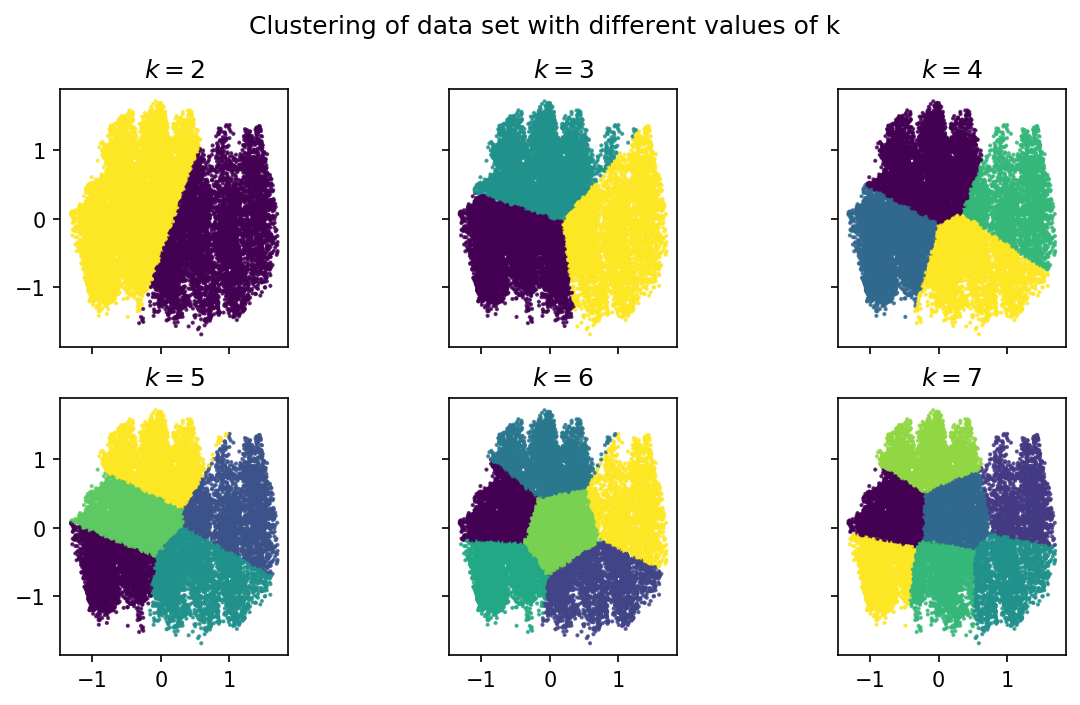

In [54]:
results = cluster_range(X_nongeo, KMeans(random_state=1337), 2, 7)
plot_clusters(X_nongeo, results['ys'])
plt.show()

Visually, k = 3 and k = 4 clustered the data well, with balanced, parsimonius and no overlapping clusters. 

For a more objective assessement, clustering was also assessed based on internal validation criteria. From the figure, the SSE has an 'elbow' at k =3 suggesting this is the optimal number of clusters.

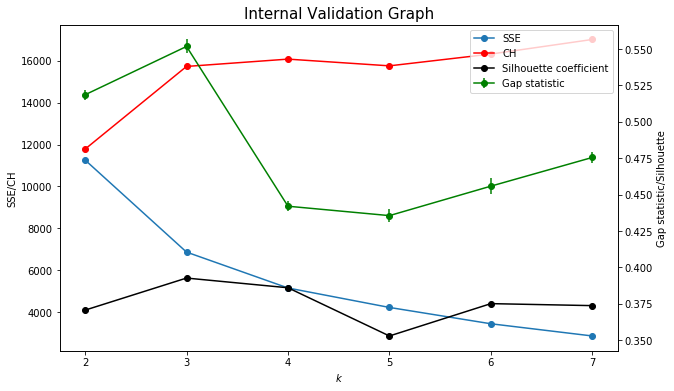

In [55]:
plot_internal(results['inertias'], results['chs'], results['scs'],
              results['gss'], results['gssds'])
plt.title('Internal Validation Graph', fontsize=15)
plt.show()

We will postpone the EDA into the clusters for now, and examine how the clusters are distributed across Los Angeles. Here is an example of the listings when plotted geographically (Longitude vs Latitude) while distinguishing the cluster that the listings belong to. We can see that some clusters are dominant in some neighbourhoods while it appears to be mixed for others.

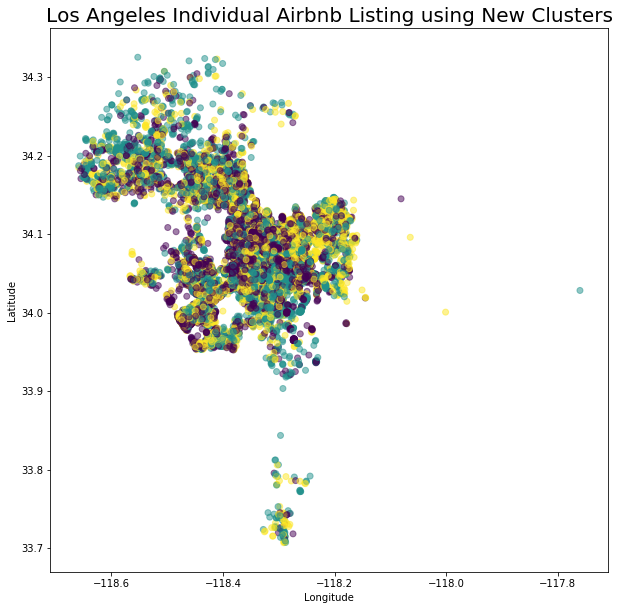

In [174]:
agg = KMeans(n_clusters=3)
predict = agg.fit_predict(X_nongeo)

fig = plt.figure(figsize=(10, 10))

plt.scatter(df_geo.longitude, df_geo.latitude, c=predict, alpha=0.5)
plt.title('Los Angeles Individual Airbnb Listing using New Clusters', 
          fontsize=20)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

**Neighbourhood Labelling**

Next, we find the dominant clusters within each neighbourhood. Each neighbourhood will then be labelled according to the dominant clusters within.

In [175]:
predict_dummies = pd.get_dummies(
    pd.DataFrame({'cluster': 2 - predict}).replace({1 : 2, 2 : 1}).astype(str))

df_neigh = pd.concat(
    [df_nongeo, bow_text, df_geo, predict_dummies],
    axis=1)

df_label = df_neigh.loc[:, ['neighbourhood_cleansed',
                            'cluster_0', 'cluster_1', 'cluster_2']]
df_label = df_label.groupby('neighbourhood_cleansed').sum()
df_label['cluster'] = df_label.idxmax(axis=1).str[-1].astype(int)

df_label

cluster_0  cluster_1  cluster_2  cluster
neighbourhood_cleansed                                          
Adams-Normandie              11.0        5.0       30.0        2
Alhambra                      0.0        0.0        1.0        2
Arleta                        1.0        0.0        5.0        2
Arlington Heights            18.0       23.0      110.0        2
Athens                        0.0        1.0        1.0        1
...                           ...        ...        ...      ...
Willowbrook                   0.0        1.0        3.0        2
Wilmington                    4.0        1.0        9.0        2
Windsor Square               14.0       12.0       12.0        0
Winnetka                      7.0       13.0       32.0        2
Woodland Hills               67.0       55.0      114.0        2

[142 rows x 4 columns]

Here is what the geographical plot looks when the neighbourhoods are colored according to their assigned labels.

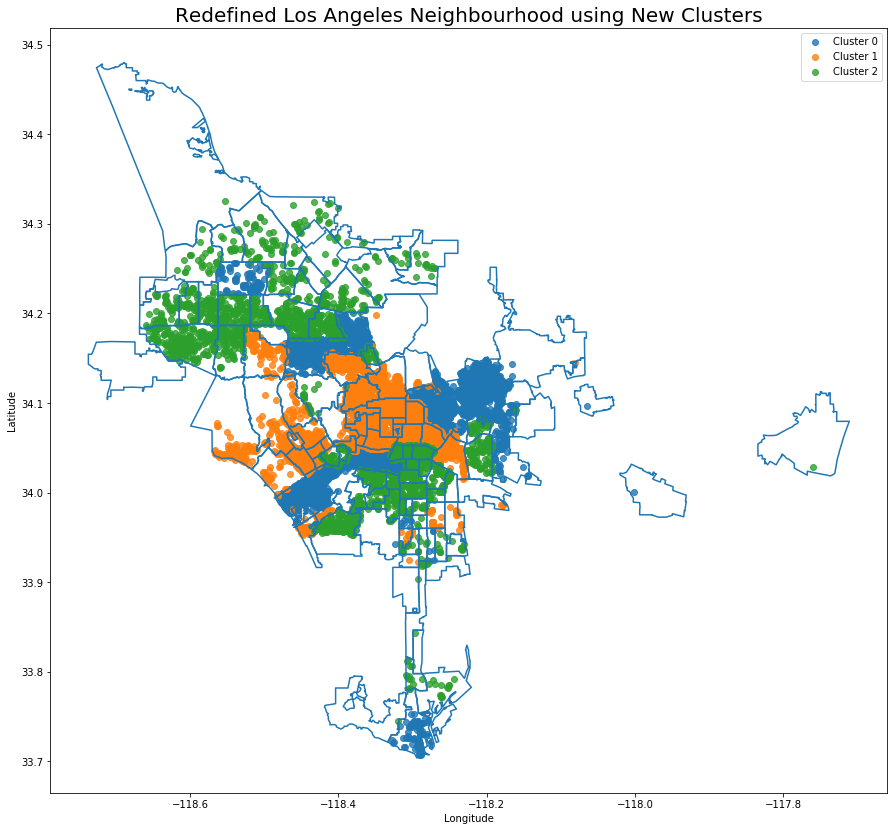

In [176]:
geo = geopandas.read_file('neighbourhoods.geojson')
geo_label = pd.merge(
    geo, df_label, right_on='neighbourhood_cleansed', left_on='neighbourhood')
gdf = geopandas.GeoDataFrame(geo_label, geometry='geometry')

df_neigh['cluster'] = df_neigh.neighbourhood_cleansed.apply(
    lambda x: df_label.loc[x].cluster).astype(int)

fig, ax = plt.subplots(figsize=(15, 15))
gdf.boundary.plot(ax=ax)
for i in range(0, 3):
    ax.scatter(df_neigh[df_neigh.cluster == i].longitude, 
               df_neigh[df_neigh.cluster == i].latitude, 
               label="Cluster " +str(i),
               alpha=0.8)
ax.set_title(
    'Redefined Los Angeles Neighbourhood using New Clusters', fontsize=20)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.legend()
plt.show()

While the locations of the clusterings can already make sense to those familiar with LA, we want to verify these with our EDA.

<div style="width: 180px;height: 50px;border: 3px solid black;box-sizing: border-box;text-align: center;vertical-align: middle;line-height: 45px;font-size: 20px;color:#DD1316;font-weight: bold;">INSIGHTS/EDA</div>

The EDA doubles as the results section, as we will use the EDA to characterize clusters and later choose appropriate titles for each cluster label.

We set aside a dataframe specifically for EDA.

In [177]:
df_eda = pd.concat([df_nongeo, pd.DataFrame({'cluster' : predict})], axis = 1)
df_eda

host_since  host_response_time  host_is_superhost  host_listings_count  \
0          4342.0                 0.0                1.0                  2.0   
1          4172.0                 0.0                1.0                  8.0   
2          4172.0                 0.0                1.0                  8.0   
3          4172.0                 0.0                1.0                  8.0   
4          4342.0                 0.0                1.0                  2.0   
...           ...                 ...                ...                  ...   
18942      2161.0                 0.0                0.0                 49.0   
18943      2161.0                 0.0                0.0                 49.0   
18944      2161.0                 0.0                0.0                 49.0   
18945      2161.0                 0.0                0.0                 49.0   
18946      1674.0                 1.0                0.0                  2.0   

       host_verifications  host_has_profile_pic  host_identity_verified  \
0                     5.0                   1.0                     1.0   
1                     9.0                   1.0                     0.0   
2                     9.0                   1.0                     0.0   
3                     9.0                   1.0                     0.0   
4                     5.0                   1.0                     1.0   
...                   ...                   ...                     ...   
18942                10.0                   1.0                     1.0   
18943                10.0                   1.0                     1.0   
18944                10.0                   1.0                     1.0   
18945                10.0                   1.0                     1.0   
18946                 6.0                   1.0                     0.0   

       is_location_exact  accommodates  bathrooms  ...  bed_type_Futon  \
0                    1.0             1        1.5  ...               0   
1                    1.0             2        1.0  ...               0   
2                    1.0             3        1.0  ...               0   
3                    1.0             5        1.0  ...               0   
4                    1.0             1        1.5  ...               0   
...                  ...           ...        ...  ...             ...   
18942                1.0             6        1.0  ...               0   
18943                1.0             4        1.0  ...               0   
18944                1.0             6        1.5  ...               0   
18945                1.0             5        1.0  ...               0   
18946                1.0             5        3.5  ...               0   

       bed_type_Pull-out Sofa  bed_type_Real Bed  \
0                           0                  1   
1                           0                  1   
2                           0                  0   
3                           0                  1   
4                           0                  1   
...                       ...                ...   
18942                       0                  1   
18943                       0                  1   
18944                       0                  1   
18945                       0                  1   
18946                       0                  1   

       cancellation_policy_flexible  cancellation_policy_moderate  \
0                                 0                             0   
1                                 0                             1   
2                                 0                             1   
3                                 0                             1   
4                                 0                             0   
...                             ...                           ...   
18942                             0                             0   
18943                             0                             0  

With regards to price, there is an obvious difference between the three clusters. Note that the x-axis is plotted in log scale so differences are actually much larger.

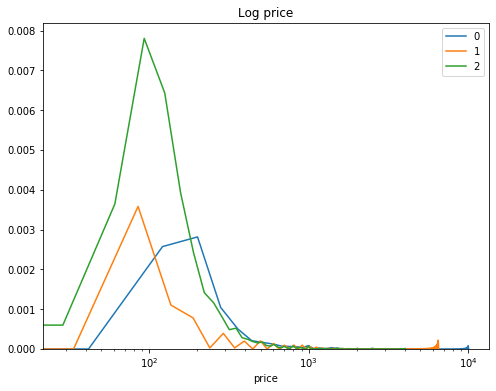

In [178]:
fig = plt.figure(figsize = (8,6))
plt.title('Log price')

for i in sorted(df_eda.cluster.unique()):
    sns.distplot(df_eda[df_eda.cluster == i].price, label = i, hist = False)

    plt.xscale('log')
plt.show()

Upon closer examination, there are obvious and consistent gaps in the mean prices of clusters. Cluster 2 is the cheapest among all the clusters while Cluster 0 is the most expensive

In [179]:
df_clusters = df_eda.groupby('cluster').mean()

In [180]:
df_clusters.iloc[:, 12:17].transpose()

cluster                    0           1           2
price             211.363855  105.542988  165.306467
security_deposit  342.625167  159.811889  275.642791
cleaning_fee      106.472289   41.885697   85.325340
guests_included     2.453681    1.437662    2.188892
extra_people       19.177644   16.229005   17.284035

The mean accommodation capacity, bathrooms and bedrooms are also reflective of the price. It seems that more expensive clusters are consistently larger and more elaborate too to accommodate for more rooms.

In [181]:
df_clusters.iloc[:, 8:13].transpose()

cluster                0           1           2
accommodates    4.643775    2.574307    3.896349
bathrooms       1.501004    1.492120    1.328434
bedrooms        1.506827    1.176342    1.377166
beds            2.378179    1.723319    1.992265
price         211.363855  105.542988  165.306467

More expensive listings do not necessarily correlate to higher review scores. There are little and inconsistent differences in reviews among clusters, which implies no correlation between the price and review scores.

In [182]:
df_clusters.iloc[:, 25:32].transpose()

cluster                              0          1          2
review_scores_rating         92.196921  93.642729  96.168162
review_scores_accuracy        9.433333   9.556353   9.798886
review_scores_cleanliness     9.248996   9.317574   9.614480
review_scores_checkin         9.589960   9.727110   9.872834
review_scores_communication   9.569880   9.693198   9.877011
review_scores_location        9.608969   9.593058   9.802754
review_scores_value           9.155154   9.426092   9.599010

In terms of property and room type, 

Cluster 2 is most likely to be a private room within a shared house. Cluster 0 and 1 most likely offers sole occupation of an Apartment, sometimes a House and rarely a Guest House.

In [183]:
prop = ['property_type_Condominium', 'property_type_Apartment',
        'property_type_House', 'property_type_Guest suite',
       'property_type_Bungalow', 'property_type_Guesthouse', 
       'property_type_Loft', 'property_type_Townhouse',
       'room_type_Entire home/apt',
       'room_type_Private room', 'room_type_Shared room']
df_clusters.loc[:,prop].transpose()

cluster                           0         1         2
property_type_Condominium  0.043909  0.045482  0.045483
property_type_Apartment    0.619411  0.096948  0.375928
property_type_House        0.145515  0.690604  0.228806
property_type_Guest suite  0.023695  0.022940  0.083075
property_type_Bungalow     0.018608  0.020347  0.047184
property_type_Guesthouse   0.043106  0.009575  0.132890
property_type_Loft         0.038153  0.013365  0.031405
property_type_Townhouse    0.014726  0.027528  0.021658
room_type_Entire home/apt  0.894378  0.093357  0.912902
room_type_Private room     0.068407  0.762817  0.078589
room_type_Shared room      0.022758  0.121085  0.006652

#### Cluster themes

To identify the dominant themes among the clusters, we also identify the most relevant and frequent words used in the listing's description. These are represented by the word clouds shown below.

In [184]:
df_text1 = pd.concat([df_text, pd.DataFrame({'cluster' : predict})], axis = 1)

In [185]:
def word_cloud(data, variable, cluster):
    """Returns word cloud representation based on a data frame column"""
    text = data.query(f'cluster=={cluster}')[
        variable].str.findall(r'\b([a-z]+)\b').values
    str1 = ' '
    for i in text:
        string1 = " ".join(i)
        str1 = str1 + string1
    #stop words were defined as these are ubiquitous terms among the clusters
    stop_words = ['walking distance', 'living room', 'away',
                  'from', 'home', 'area', 'house', 'space', 'guest', 'unit',
                  'bedroom', 'room', 'well', 'have', 'access', 'bath',
                  'washer dryer', 'your', 'stay', 'will', 'neighborhood',
                  'available', 'private', 'apartment', 'enjoy', 'pool',
                  'place', 'beautiful', 'place', 'los angeles', 'studio', 
                  'great', 'heart', 'offer', 'block', 'entrance', 
                  'building', 'located','location']
    
    for word in stop_words:
        str1 = str1.replace(word, '')

    wordcloud = WordCloud(background_color = 'white',
                          width=1000, height=500, max_words=10000,
                          min_word_length=4).generate(str1.lower())
    
    fig = plt.figure(figsize=(12, 12), dpi=200)
    plt.imshow(wordcloud)
    plt.title(f"Dominant themes for cluster {cluster}")
    plt.axis("off")
    plt.show()

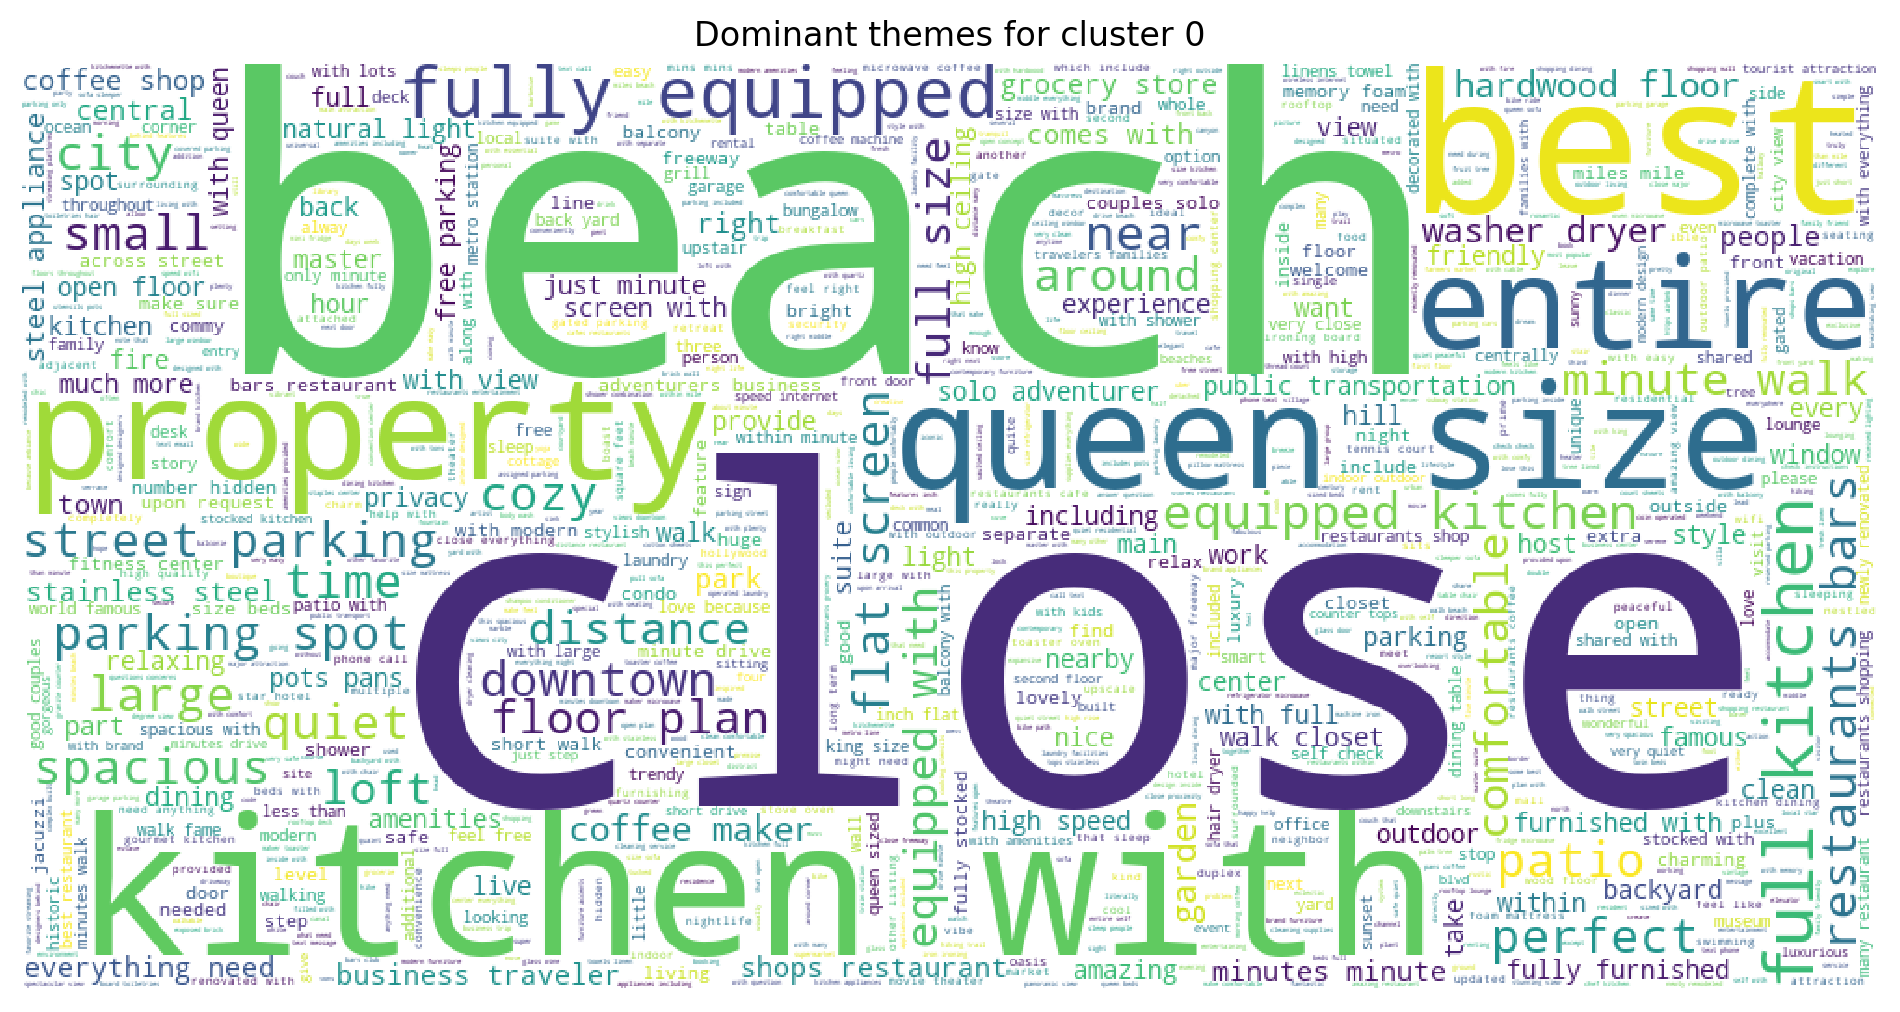

In [186]:
#Running this cell changes the word cloud shown below. 
word_cloud(df_text1,'description',0)

The dominant theme among cluster 0 is "beach", "close" and best. Based on how listings belonging to this cluster were mapped out on LA's districts, it can be observed that these are located at the heart and along the coast lines of Los Angeles. As shown, cluster 0 also has the highest average price among the clusters and this descriptions such as "best", "fully equipped" justifies this.

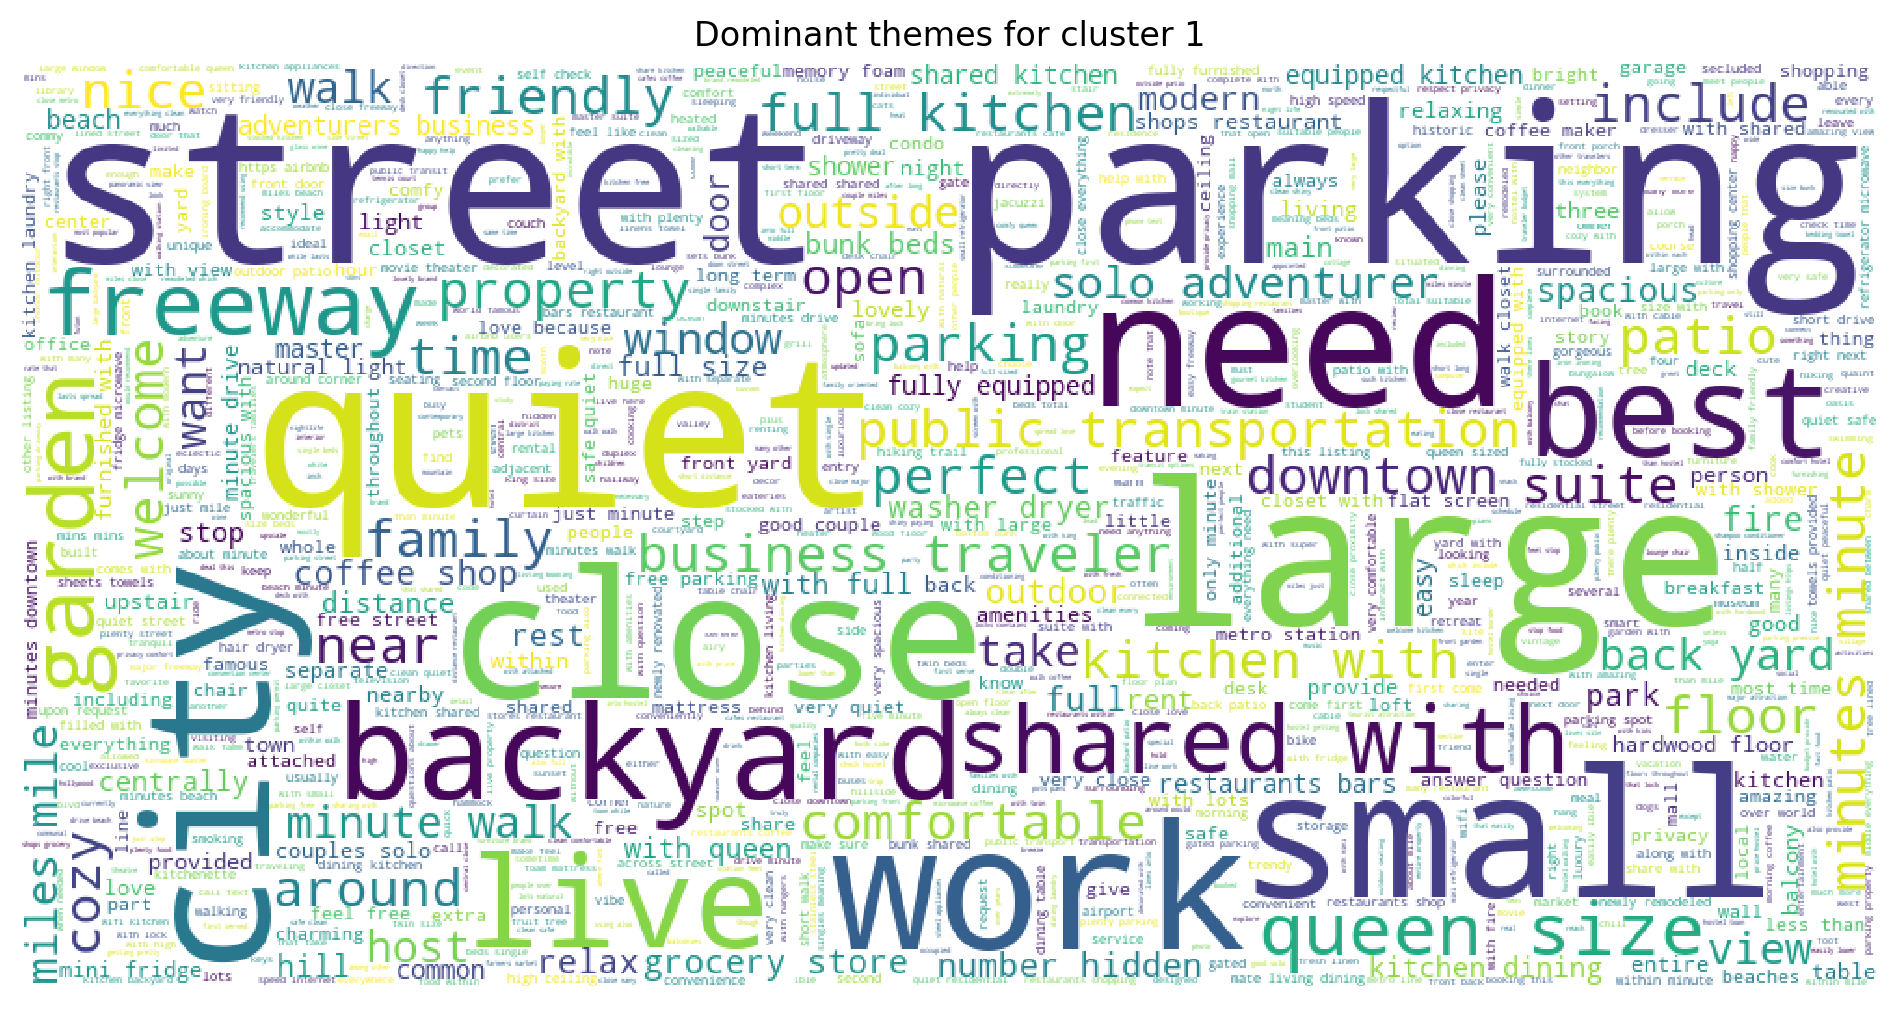

In [187]:
#Running this cell changes the word cloud shown below. 
word_cloud(df_text1,'description',1)

Cluster 1 does not have a sole dominant theme compared to Cluster 0. As shown, Cluster 1 has contrasting descriptions such as large, small and also descriptions such as "work","quiet","city","quiet" and "street parking". This implies a more diverse listing, and hence, caters to a wider range of customers. It is also suited for business or for leisure. 

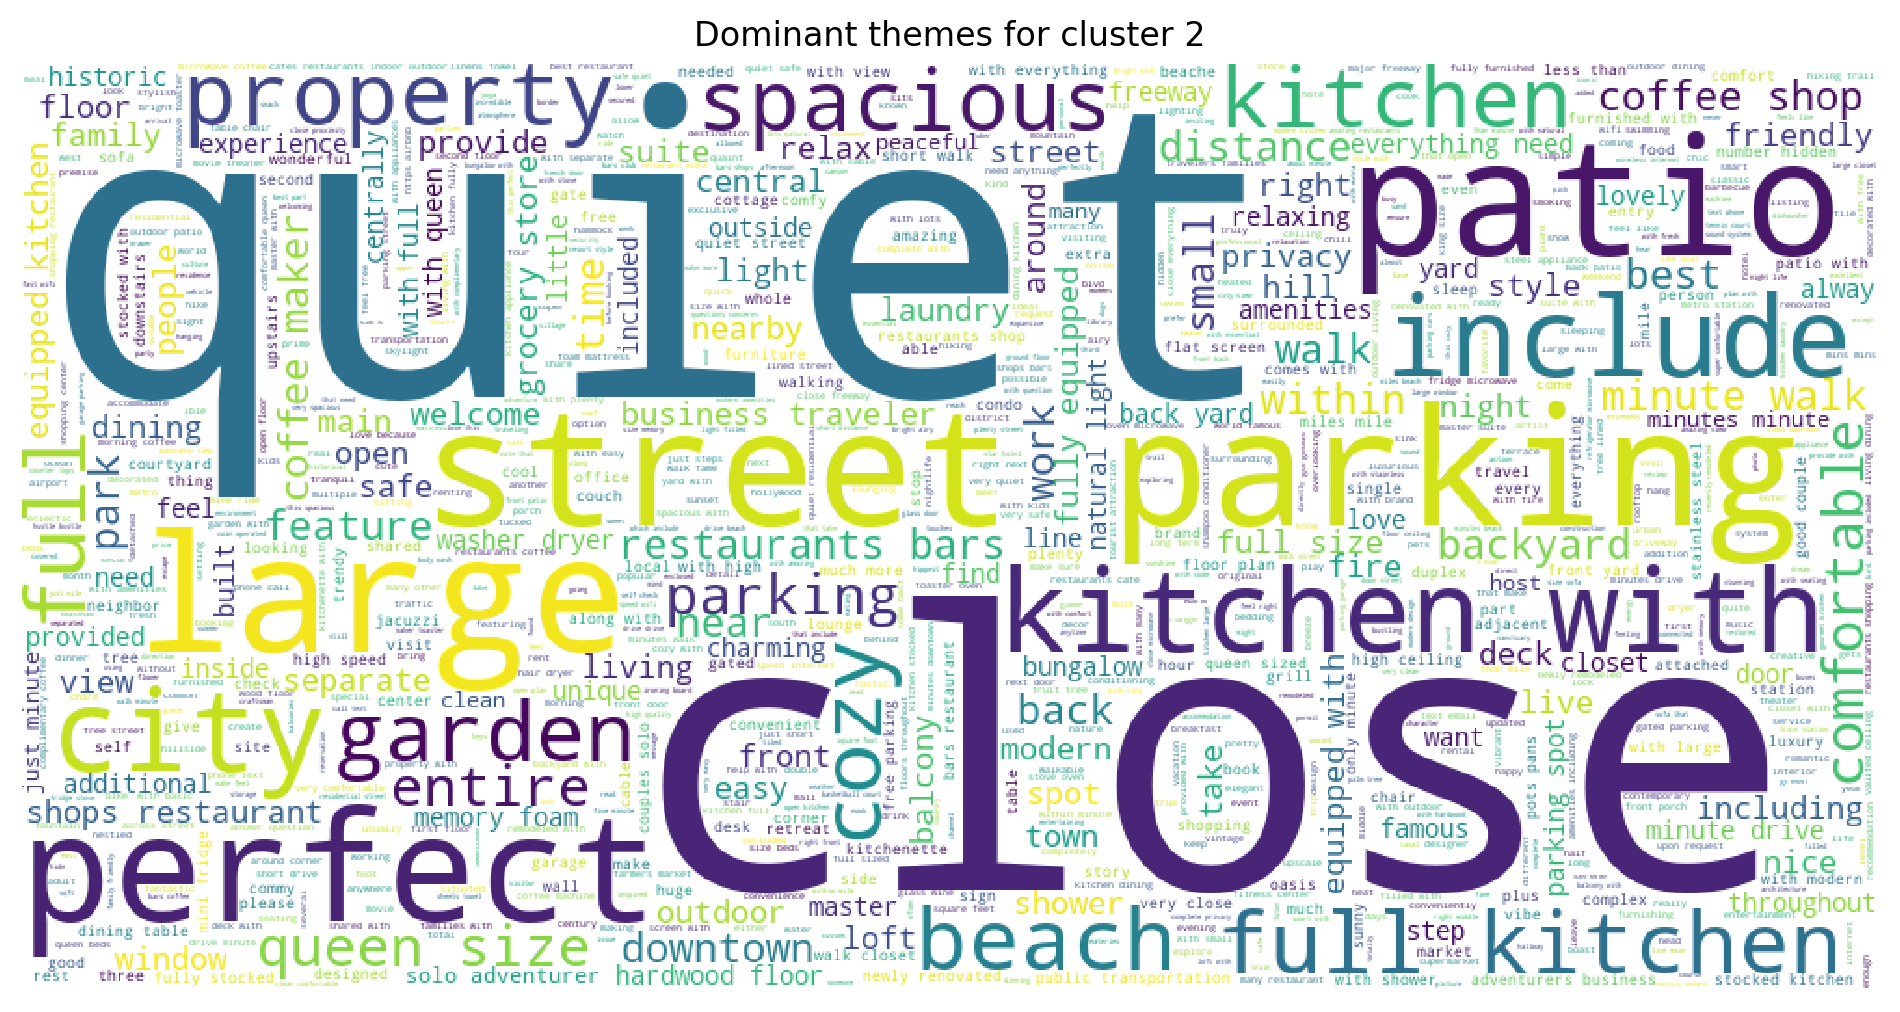

In [188]:
#Running this cell changes the word cloud shown below. 
word_cloud(df_text1,'description',2)

For cluster 2, the most dominant theme is "quiet". The listings under these clusters are shown to be located at LA's residential districts, and hence, could be the reason why "quiet" is the dominant theme for this cluster. This could be for travellers who want some peace and quiet, and likely far from the city.

With enough EDA into the clusters, we can safely label them henceforth:

- Cluster 0: Prime LA

	These neighbourhoods are in the parts of LA that the movies show; they are located in the beating heart of LA. They include the vicinity of Santa Monica beach, HollyWood, and DownTown LA. Listings here are more expensive and larger on average. They offer sole occupation of an Apartment, Condominium or House on the higher-end of the luxury scale.

- Cluster 1: Business / Tourist

	These neighbourhoods are in strategic locations throughout LA. They include the business centers such as Mid LA, the LA airport, areas near theme parks, and the busy port of San Pedro. Listings here are more reasonable priced, but are also smaller compared to Prime LA listings. They offer sole occupation of an Apartment, Condominium or House on the mid-end of the luxury scale.

- Cluster 2: Residential / Outskirts

	These neighbourhoods are in the quiet areas of LA, though not necessarily far from the center of LA. They include south LA, most of northern LA near parks, mountains and canyons, and literal residential areas. Listings here are priced for budget travellers. They offer a private room within the host's house and are definitely more casual and wallet-friendly than the other two clusters.

<div style="width: 430px;height: 50px;border: 3px solid black;box-sizing: border-box;text-align: center;vertical-align: middle;line-height: 45px;font-size: 20px;color:#DD1316;font-weight: bold;">CONCLUSION AND RECOMMENDATION</div>

A dataset of AirBnB listings within Los Angeles City were clustered based on non-geographic information and text information including the listing description, amenities and space information. These text informations were vectorized using the Term Frequency-Inverse Document Frequency (TFIDF) vectorization. From here, neighbourhoods were labelled according to the dominant cluster of listings within them.

To give an appropriate title/description to the clusters (and neighbourhoods), EDA was performed on the non-geographic information and text information of the clusters to see their defining factors. For non-geographic features, the mean values of all listings were observed. Clear and consistent patterns across different features were observed, which served to reinforce the description of the clusters. These were cross referenced with the EDA from the text information which was done visually using a Word Cloud. The EDA from both types of information were cross referenced and found to agree.

Finally, after reinforcing the characteristics of each cluster, they were assigned titles which appropriately described them:
- Prime LA: Neighbourhoods mainly at the heart of LA. Listings here are often expensive and offer sole occupation of condominiums and houses.
- Business / Tourist: Neighbourhoods mainly near tourist spots and within business centers. Listings here are mid-priced but usually still offer sole occupation of property.
- Residential / Outskirts: Neighbourhoods mostly in the quiet areas of LA, farther from the hubs. Listings here are the cheapest, and mostly offer a room within a shared house.

The labels on these neighbourhoods can better described which 'side' of LA they are part of.

<div style="width: 450px;height: 50px;border: 3px solid black;box-sizing: border-box;text-align: center;vertical-align: middle;line-height: 45px;font-size: 20px;color:#DD1316;font-weight: bold;">REFERENCES AND ACKNOWLEDGEMENTS</div>

[1] http://insideairbnb.com/los-angeles/